# CS597 PA1 Implement Multi-Layer Perceptron Using PyTorch (100 pts)

### Description
In this Programming Assignment (PA), we aim to get familiar with the PyTorch framework.
Specifically, we need to complete the coding tasks in the Jupyter Notebook Download Jupyter Notebook(the points for each part are clearly stated).
After completing the tasks, please export the notebook as a PDF file and submit both the PDF file and the notebook to Canvas.

In [1]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm

/home/adam-torek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the MNIST dataset

In [95]:
# Load MNIST dataset
# ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train data
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test data
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Examine your model on the MNIST dataset

In [104]:
# Build your Multi-Layer Perceptron (MLP) model (20 pts)

class MLP(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        """Initialize a basic multi layer perceptron module with a 
        single hidden layer."""
        super(MLP, self).__init__()
        
        # Flatten the input image so it can fit into the input layer
        self.flatten = torch.nn.Flatten()
        # Create the input layer that takes in a flattened MNIST image and projects
        # it into the hidden layer
        self.inp = torch.nn.Linear(in_features=input_size, out_features=hidden_size)
        # Use basic sigmoid activation functions between the hidden and linear layer
        self.act1 = torch.nn.Sigmoid()
        # Create the hidden layer and hidden layer sigmoid activation function with
        # the given hidden size
        self.hid = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.act2 = torch.nn.Sigmoid()
        # Create the output layer that takes in the hidden layer's output and 
        # produces a probability estimate for all 10 MNIST digit classes. This layer
        # also uses a softmax function to convert the output values into a probability
        # distribution that sums to 1. Softmax at the output layer is industry standard
        # for deep learning. 
        self.out = torch.nn.Linear(in_features=hidden_size, out_features=output_size)
        self.lastout = torch.nn.Softmax(dim=0)

    def forward(self, x):
        """Takes the given MNIST image and sends it through all the layers of the 
        layers of the MLP model. This function will produce a probability distribution
        that sums to 1 across all MNIST digits."""
        # Flatten the given MNIST image
        flattened = self.flatten(x)
        # Send the flattened image through the input layer
        in_res = self.act1(self.inp(flattened))
        # Send the hidden layer's output through the hidden layer
        hid_res = self.act2(self.hid(in_res))
        # Get the softmax distribution across all 10 MNIST classes
        # from the hidden layer's result and return it
        out_res = self.lastout(self.out(hid_res))
        return out_res


In [105]:
# Instantiate the MLP model (10 pts)

# Gather all possible image classes
class_set = set()
# Add all of the image classes to the set of images
# to get the correct output size
for _, image_class in iter(train_dataset):
    class_set.add(image_class)

first_data = next(iter(train_dataset)) # Get the first image of the dataset
input_size = first_data[0].flatten().size()[0]  # what's input size? hints: flattened size for one instance
hidden_size = 100 # define on your own
output_size = len(class_set)  # what's output size for this classification tasks?
mlp_model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)


In [106]:
# Define the loss function and optimizer (10 pts)

learning_rate = 0.0001 # define your own learning rate here
loss_fn = torch.nn.CrossEntropyLoss()  # which loss function should we use here?
optimizer = torch.optim.Adam(params=mlp_model.parameters(), lr=learning_rate)  # which optimizer do you use?
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Select either the GPU or CPU for training and inference 
                                                        #depending on which is available


In [107]:
# Train the model (30 pts)

def train(train_loader, mlp_model, num_epochs):
    """Train the model."""
    # Move the given model to the correct training device
    mlp_model = mlp_model.to(device)
    # Train the model on the MNIST training dataset num_epochs times
    for _ in range(0, num_epochs):
        # Iterate over the training dataset batches once
        for inputs, labels in tqdm.tqdm(train_loader):
            # Zero the optimizer to prevent gradient accumulation
            optimizer.zero_grad()
            # Move the inputs and correct labels over to
            # the PyTorch Model's device
            inputs = inputs.to(device) 
            labels = labels.to(device)
            # Get the predicted outputs from the PyTorch Model
            outputs = mlp_model(inputs)
            # Calculate the cross entropy loss
            loss = loss_fn(outputs, labels)
            # Propagate the loss backward through the PyTorch model's gradients
            loss.backward()
            # Use the optimizer to update the PyTorch model's weights
            optimizer.step()


num_epochs = 10  # feel free to change the number of training epochs
train(train_loader, mlp_model, num_epochs)


100%|██████████| 938/938 [00:05<00:00, 158.68it/s]


In [108]:
# Evaluation by test accuracy (10 pts)

def evaluation(test_loader):
    """Evaluate the model on the test data."""
    # Turn off torch gradients for evaluation since 
    # they are not needed
    with torch.no_grad():
        # Collect all correct label predictions and 
        # all samples seen for averaging
        total_correct = 0
        total_seen = 0
        # Iterate through all inputs and labels by batch
        # in the MIST test dataset
        for inputs, labels in test_loader:
            # Move inputs and labels to the correct PyTorch device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Get the prediction probabilities from the model
            outputs = mlp_model(inputs)
            # Select the labels with the highest probability as the model predictions
            predicted_labels = torch.argmax(outputs, dim=1)
            # Get the total correct predictions for this batch
            total_correct += (predicted_labels == labels).sum()
            # Get the total size of the batch for averaging
            total_seen += labels.size(0)

        # Divide the total correct predictions by the total number of test instances to get the accuracy
        total_accuracy = total_correct / total_seen
        # Print the calculated accracy once calculated
        print("The evaluation accuracy on the test dataset is %.3f percent" % total_accuracy)

evaluation(test_loader)


The evaluation accuracy on the test dataset is 0.892 percent


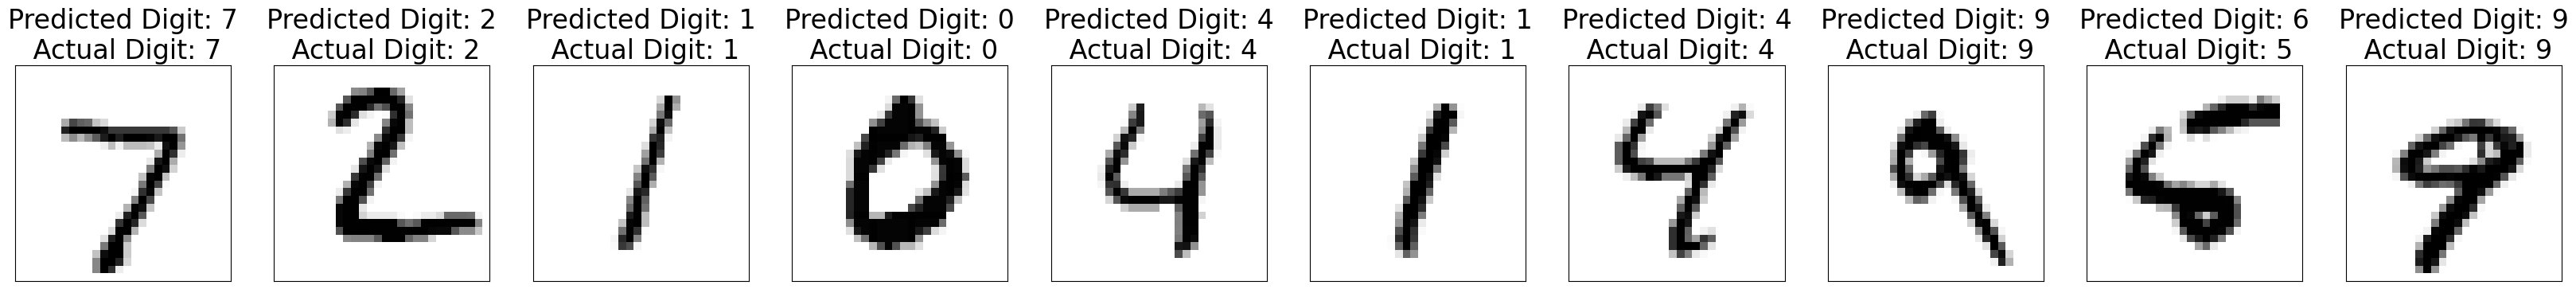

In [111]:
# Visualization (20 pts)

def prediction(data):
    """Make predictions on the given dataset."""
    data = data.to(device)
    probability_vals = mlp_model(data)
    predicted_labels = torch.argmax(probability_vals, dim=1)
    return predicted_labels

def visualization(data, labels, num_data=10):
    """Visualize the given data and its prediction."""
    # make predictions
    predictions = prediction(data)
    # Create subplots and adjust size properly to make sure everything fits
    _, axes = plt.subplots(nrows=1, ncols=num_data)
    plt.subplots_adjust(left=5, right=10)
    # Show all digits, predicted digit, and actual digit
    for i in range(0, num_data):
        # Show the digit image in binary
        axes[i].imshow(data[i].squeeze(), cmap=plt.cm.binary)
        # Turn off the axis ticks so they don't get in the awy
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        # Set the title of the subplots to the predicted digits from the model
        # and actual digits that were received
        axes[i].set_title("Predicted Digit: " + str(predictions[i].item()) + "\n Actual Digit: " + str(labels[i].item()), fontsize=24)

# Load a batch of test data
data, labels = next(iter(test_loader))

# Visualize 10 test instances
num_data = 10
assert num_data <= batch_size
visualization(data, labels, num_data)
